In [1]:
# import packages

In [2]:
from pandas.io.json import json_normalize
import json
from pandasql import sqldf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import io
import requests
import json
import base64
import datetime
from urllib.parse import urlencode

In [3]:
# client id

In [4]:
client_id = '6e24789ec7874259a220f747fcd7e93e'
client_secret = '9bd8ff1ad2f34ef6a87f00124be070b2'

In [5]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"



    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def getClientCreds(self):
        '''Returns b64 encoded string'''
        client_id = self.client_id
        client_secret = self.client_secret

        if client_id == None or client_secret == None:
            raise Exception('Must set a client id and secret')

        client_creds  = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()

    def getTokenHeader(self):
        client_creds_b64 = self.getClientCreds()
        return {
            'Authorization':f"Basic {client_creds_b64}"
        }

    def getTokenData(self):
        return {
            "grant_type":"client_credentials"
        }

    def perform_auth(self):
        token_url = self.token_url
        token_data = self.getTokenData()
        token_header = self.getTokenHeader()

        r = requests.post(token_url, data=token_data, headers=token_header)

        if r.status_code  not in range(200,299):
            raise Exception('Could not authenticate client.')
            #return False

        now = datetime.datetime.now()
        token_response_data = r.json()
        access_token = token_response_data['access_token']
        expires_in = token_response_data['expires_in']
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now


        return True

    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now= datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}", 
        }
        return headers
    
    def get_resource(self, lookup_id, resource_type='albums', version='v1'):
        endpoint = f'https://api.spotify.com/{version}/{resource_type}/{lookup_id}'
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers = headers)
        if r.status_code not in range (200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id ):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id ):
        return self.get_resource(_id, resource_type='artists')
    
    def get_playlist(self, _id):
        return self.get_resource(_id, resource_type='playlists')
    
    
    def base_search(self, query_params): #type
        access_token = self.get_access_token()
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_URL = f"{endpoint}?{query_params}"
        r = requests.get(lookup_URL, headers=headers)
        if r.status_code not in range (200, 299):
            return {}
        return r.json()
    
    def search(self, query=None, operator=None, operator_query=None, search_type='artist'):
        if query == None:
            raise Exception('A query is required')
        if isinstance(query, dict):
            query = ' '.join([f'{k}:{v}' for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == 'or' or operator.lower() == 'not':
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f'{query} {operator} {operator_query}'
        query_params = urlencode({'q': query, 'type': search_type.lower()})
        return self.base_search(query_params)

In [6]:
spotify = SpotifyAPI(client_id, client_secret)

# radioactive

In [7]:
radioactive = spotify.search({'track': 'Radioactive', 'artist': 'Imagine'}, search_type ='track')
radioactive

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ARadioactive+artist%3AImagine&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/53XhwfbYqKCa1cC15pYq2q'},
       'href': 'https://api.spotify.com/v1/artists/53XhwfbYqKCa1cC15pYq2q',
       'id': '53XhwfbYqKCa1cC15pYq2q',
       'name': 'Imagine Dragons',
       'type': 'artist',
       'uri': 'spotify:artist:53XhwfbYqKCa1cC15pYq2q'}],
     'available_markets': ['CA', 'US'],
     'external_urls': {'spotify': 'https://open.spotify.com/album/6htgf3qv7vGcsdxLCDxKp8'},
     'href': 'https://api.spotify.com/v1/albums/6htgf3qv7vGcsdxLCDxKp8',
     'id': '6htgf3qv7vGcsdxLCDxKp8',
     'images': [{'height': 640,
       'url': 'https://i.scdn.co/image/ab67616d0000b273b2b2747c89d2157b0b29fb6a',
       'width': 640},
      {'height': 300,
       'url': 'https://i.scdn.co/image/ab67616d00001e02b2b2747c89d2157b0b29fb6a',
      

In [8]:
test = pd.DataFrame.from_dict(radioactive,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,156


In [9]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'single', 'artists': ..."
2,"{'album': {'album_type': 'album', 'artists': [..."
3,"{'album': {'album_type': 'album', 'artists': [..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'album', 'artists': [..."
6,"{'album': {'album_type': 'single', 'artists': ..."
7,"{'album': {'album_type': 'single', 'artists': ..."
8,"{'album': {'album_type': 'album', 'artists': [..."
9,"{'album': {'album_type': 'album', 'artists': [..."


In [11]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[CA, US]",1,186813,False,{'isrc': 'USUM71201074'},{'spotify': 'https://open.spotify.com/track/4G...,https://api.spotify.com/v1/tracks/4G8gkOterJn0...,4G8gkOterJn0Ywt6uhqbhp,False,Radioactive,72,https://p.scdn.co/mp3-preview/43288a26d88c84b0...,1,track,spotify:track:4G8gkOterJn0Ywt6uhqbhp
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,276040,True,{'isrc': 'USUM71400693'},{'spotify': 'https://open.spotify.com/track/69...,https://api.spotify.com/v1/tracks/69yfbpvmkIaB...,69yfbpvmkIaB10msnKT7Q5,False,Radioactive,65,https://p.scdn.co/mp3-preview/4a93ec26bf1ef918...,1,track,spotify:track:69yfbpvmkIaB10msnKT7Q5
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[MX, US]",1,186813,False,{'isrc': 'USUM71201074'},{'spotify': 'https://open.spotify.com/track/58...,https://api.spotify.com/v1/tracks/58rFzMvW9kxN...,58rFzMvW9kxNwMtGTgBQoP,False,Radioactive,64,https://p.scdn.co/mp3-preview/43288a26d88c84b0...,1,track,spotify:track:58rFzMvW9kxNwMtGTgBQoP
3,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,186813,False,{'isrc': 'USUM71201074'},{'spotify': 'https://open.spotify.com/track/5Y...,https://api.spotify.com/v1/tracks/5Yj7eY0cs6wk...,5Yj7eY0cs6wkGsn5mxy9j1,False,Radioactive,54,https://p.scdn.co/mp3-preview/1c6ea8da9a90a318...,1,track,spotify:track:5Yj7eY0cs6wkGsn5mxy9j1
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,188000,False,{'isrc': 'USUM71201074'},{'spotify': 'https://open.spotify.com/track/33...,https://api.spotify.com/v1/tracks/33DPHYA8bJst...,33DPHYA8bJstGIMXkz1lFt,False,Radioactive,44,https://p.scdn.co/mp3-preview/4b9f38fd712765b7...,22,track,spotify:track:33DPHYA8bJstGIMXkz1lFt
5,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",3,270080,False,{'isrc': 'USUM71303062'},{'spotify': 'https://open.spotify.com/track/3T...,https://api.spotify.com/v1/tracks/3T09JC1tNKcH...,3T09JC1tNKcHZPhisKKUm8,False,Radioactive - Live London Sessions / 2013,49,https://p.scdn.co/mp3-preview/e6df45f1c34c71af...,13,track,spotify:track:3T09JC1tNKcHZPhisKKUm8
6,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AT, AU, BE, CA, CH, CW, DE, DK, EE, ES, F...",1,270160,False,{'isrc': 'USUM71303062'},{'spotify': 'https://open.spotify.com/track/7u...,https://api.spotify.com/v1/tracks/7ukrAoAILpGP...,7ukrAoAILpGPHaZ9uYmNL0,False,Radioactive - Live London Sessions / 2013,40,https://p.scdn.co/mp3-preview/d09e038a79ba0570...,1,track,spotify:track:7ukrAoAILpGPHaZ9uYmNL0
7,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, BB, BE, BF, BH, BY, CA, DZ, EG, ES, FR, G...",1,276040,False,{'isrc': 'USUM71400767'},{'spotify': 'https://open.spotify.com/track/5e...,https://api.spotify.com/v1/tracks/5e3HJBYbAVb8...,5e3HJBYbAVb83D85z8k60X,False,Radioactive,30,https://p.scdn.co/mp3-preview/8449c5f0273bb35b...,1,track,spotify:track:5e3HJBYbAVb83D85z8k60X
8,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",3,403693,False,{'isrc': 'USUM71400273'},{'spotify': 'https://open.spotify.com/track/2o...,https://api.spotify.com/v1/tracks/2oWTWONg6QFS...,2oWTWONg6QFSwKAPqmBszv,False,Radioactive - Live From Red Rocks / 2014,42,https://p.sc

# sail

In [12]:
sail = spotify.search({'track': 'Sail', 'artist': 'AWOL'}, search_type ='track')
sail

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ASail+artist%3AAWOL&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4njdEjTnLfcGImKZu1iSrz'},
       'href': 'https://api.spotify.com/v1/artists/4njdEjTnLfcGImKZu1iSrz',
       'id': '4njdEjTnLfcGImKZu1iSrz',
       'name': 'AWOLNATION',
       'type': 'artist',
       'uri': 'spotify:artist:4njdEjTnLfcGImKZu1iSrz'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ',
  

In [13]:
test = pd.DataFrame.from_dict(sail,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,None
offset,0
previous,None
total,16


In [14]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'album', 'artists': [..."
2,"{'album': {'album_type': 'album', 'artists': [..."
3,"{'album': {'album_type': 'single', 'artists': ..."
4,"{'album': {'album_type': 'album', 'artists': [..."
5,"{'album': {'album_type': 'single', 'artists': ..."
6,"{'album': {'album_type': 'album', 'artists': [..."
7,"{'album': {'album_type': 'album', 'artists': [..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'album', 'artists': [..."


In [16]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,259093,False,{'isrc': 'USP6L1000053'},{'spotify': 'https://open.spotify.com/track/7u...,https://api.spotify.com/v1/tracks/7ueP5u2qkdZb...,7ueP5u2qkdZbIPN2YA6LR0,False,Sail,74,https://p.scdn.co/mp3-preview/39fe4367061eac83...,10,track,spotify:track:7ueP5u2qkdZbIPN2YA6LR0
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,209276,False,{'isrc': 'USP6L1280129'},{'spotify': 'https://open.spotify.com/track/24...,https://api.spotify.com/v1/tracks/24mf5NTXbNe1...,24mf5NTXbNe1de7w6rjaEn,False,Sail - Feed Me Remix,53,https://p.scdn.co/mp3-preview/a6e773d08a3ea3c2...,39,track,spotify:track:24mf5NTXbNe1de7w6rjaEn
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,349654,False,{'isrc': 'USP6L1180110'},{'spotify': 'https://open.spotify.com/track/3k...,https://api.spotify.com/v1/tracks/3kX6cdhy9XQB...,3kX6cdhy9XQBPL81GvEt0Q,False,Sail - Unlimited Gravity Remix,46,https://p.scdn.co/mp3-preview/72f0893e5def96e4...,41,track,spotify:track:3kX6cdhy9XQBPL81GvEt0Q
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,349537,False,{'isrc': 'USP6L1180110'},{'spotify': 'https://open.spotify.com/track/7q...,https://api.spotify.com/v1/tracks/7qAWdfgvuDJQ...,7qAWdfgvuDJQlhjppYtAfA,False,Sail - Unlimited Gravity Remix,43,https://p.scdn.co/mp3-preview/9ae4e713856763d3...,1,track,spotify:track:7qAWdfgvuDJQlhjppYtAfA
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,240779,False,{'isrc': 'USP6L1380136'},{'spotify': 'https://open.spotify.com/track/5G...,https://api.spotify.com/v1/tracks/5GChOpEKNxYX...,5GChOpEKNxYXIRUxto2bWp,False,Sail (feat. Kendrick Lamar & Ab Soul) - TDE Remix,42,https://p.scdn.co/mp3-preview/a5081f7e73252f8c...,40,track,spotify:track:5GChOpEKNxYXIRUxto2bWp
5,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,261046,False,{'isrc': 'USP6L1180113'},{'spotify': 'https://open.spotify.com/track/1D...,https://api.spotify.com/v1/tracks/1DqGEFrotFhh...,1DqGEFrotFhhPsowbbiSJf,False,Sail - LED Remix,31,https://p.scdn.co/mp3-preview/dfcba7af50b33b9e...,4,track,spotify:track:1DqGEFrotFhhPsowbbiSJf
6,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,259092,False,{'isrc': 'USP6L1000053'},{'spotify': 'https://open.spotify.com/track/5U...,https://api.spotify.com/v1/tracks/5UGE88CogQMc...,5UGE88CogQMcdsQhwhSZce,False,Sail,30,https://p.scdn.co/mp3-preview/15d4731f7d1f1cb9...,10,track,spotify:track:5UGE88CogQMcdsQhwhSZce
7,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,278482,False,{'isrc': 'USP6L1380130'},{'spotify': 'https://open.spotify.com/track/5n...,https://api.spotify.com/v1/tracks/5n41rCn10JV7...,5n41rCn10JV7WwvgoxYY24,False,Sail - Borgore Pop the Sweating I'm Sailing Remix,22,https://p.scdn.co/mp3-preview/8a07c59856308ddf...,37,track,spotify:track:5n41rCn10JV7WwvgoxYY24
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,286959,False,{'isrc': 'USP6L1180112'},{'spotify': 'https://open.spotify.com/track/

# I'm Yours

In [17]:
Im_Yours = spotify.search({'track': 'Im Yours', 'artist': 'Jason'}, search_type ='track')
Im_Yours

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AIm+Yours+artist%3AJason&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4phGZZrJZRo4ElhRtViYdl'},
       'href': 'https://api.spotify.com/v1/artists/4phGZZrJZRo4ElhRtViYdl',
       'id': '4phGZZrJZRo4ElhRtViYdl',
       'name': 'Jason Mraz',
       'type': 'artist',
       'uri': 'spotify:artist:4phGZZrJZRo4ElhRtViYdl'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ

In [18]:
test = pd.DataFrame.from_dict(Im_Yours,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,219


In [19]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'compilation', 'artis..."
2,"{'album': {'album_type': 'compilation', 'artis..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'album', 'artists': [..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'album', 'artists': [..."


In [21]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,242946,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/1E...,https://api.spotify.com/v1/tracks/1EzrEOXmMH3G...,1EzrEOXmMH3G43AXT1y7pA,False,I'm Yours,79,https://p.scdn.co/mp3-preview/975f7acc6041b1b7...,2,track,spotify:track:1EzrEOXmMH3G43AXT1y7pA
1,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AR, AT, AZ, BA, BB, BD, B...",1,242040,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/00...,https://api.spotify.com/v1/tracks/00Dr2e9a3Ut6...,00Dr2e9a3Ut6aUVGe8IoHH,False,I'm Yours,0,https://p.scdn.co/mp3-preview/a4fd098ade918bf6...,70,track,spotify:track:00Dr2e9a3Ut6aUVGe8IoHH
2,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,242040,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/3H...,https://api.spotify.com/v1/tracks/3HN0AC9gB2DJ...,3HN0AC9gB2DJjOlPsI25br,False,I'm Yours,0,https://p.scdn.co/mp3-preview/a4fd098ade918bf6...,63,track,spotify:track:3HN0AC9gB2DJjOlPsI25br
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,242040,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/2U...,https://api.spotify.com/v1/tracks/2U9jmCadmcaJ...,2U9jmCadmcaJiGgT9FH1XM,False,I'm Yours,0,https://p.scdn.co/mp3-preview/a4fd098ade918bf6...,44,track,spotify:track:2U9jmCadmcaJiGgT9FH1XM
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,242040,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/6c...,https://api.spotify.com/v1/tracks/6cAlQrApxMYd...,6cAlQrApxMYdz9lt4FWVBH,False,I'm Yours,0,https://p.scdn.co/mp3-preview/a4fd098ade918bf6...,68,track,spotify:track:6cAlQrApxMYdz9lt4FWVBH
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,214213,False,{'isrc': 'USEE10800666'},{'spotify': 'https://open.spotify.com/track/1j...,https://api.spotify.com/v1/tracks/1jTeSfeZ4nma...,1jTeSfeZ4nmaLeAPEDfFac,False,I'm Yours - Radio Edit,0,https://p.scdn.co/mp3-preview/4c9e5bac42684029...,25,track,spotify:track:1jTeSfeZ4nmaLeAPEDfFac
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,[US],1,242040,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/2V...,https://api.spotify.com/v1/tracks/2VIRAajP1QOn...,2VIRAajP1QOneP9zJ9v2y8,False,I'm Yours,34,https://p.scdn.co/mp3-preview/c782977ab382a245...,1,track,spotify:track:2VIRAajP1QOneP9zJ9v2y8
7,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,243941,False,{'isrc': 'USEE11400815'},{'spotify': 'https://open.spotify.com/track/1j...,https://api.spotify.com/v1/tracks/1j5cGcXWdHKT...,1j5cGcXWdHKTPQ2XgXODJI,False,I'm Yours - Live on HSN Live,55,https://p.scdn.co/mp3-preview/9204645792ba99b5...,6,track,spotify:track:1j5cGcXWdHKTPQ2XgXODJI
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AR, BO, BR, BZ, CA, CL, CO, CR, DO, EC, GT, G...",1,242946,False,{'isrc': 'USEE10800667'},{'spotify': 'https://open.spotify.com/track/57...,https://api.spotify.com/v1/tracks/57URzGoYgSj0...,57URzGoYgSj0AiXclvqD6y,False,I'm Yours,34,https://p.scdn.co/mp3-preview/975f7acc6041b1b7...,1,t

# Blinding Lights

In [22]:
Blinding_Lights = spotify.search({'track': 'Blinding Lights', 'artist': 'The'}, search_type ='track')
Blinding_Lights

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ABlinding+Lights+artist%3AThe&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1Xyo4u8uXC1ZmMpatF05PJ'},
       'href': 'https://api.spotify.com/v1/artists/1Xyo4u8uXC1ZmMpatF05PJ',
       'id': '1Xyo4u8uXC1ZmMpatF05PJ',
       'name': 'The Weeknd',
       'type': 'artist',
       'uri': 'spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
    

In [23]:
test = pd.DataFrame.from_dict(Blinding_Lights,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,195


In [24]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'compilation', 'artis..."
2,"{'album': {'album_type': 'compilation', 'artis..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'single', 'artists': ..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'album', 'artists': [..."


In [26]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,200040,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0V...,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,0VjIjW4GlUZAMYd2vXMi3b,False,Blinding Lights,90,https://p.scdn.co/mp3-preview/579494c4709a8cc9...,9,track,spotify:track:0VjIjW4GlUZAMYd2vXMi3b
1,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/4m...,https://api.spotify.com/v1/tracks/4mWcNMhTh3a1...,4mWcNMhTh3a13x6e5t74cO,False,Blinding Lights,1,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,19,track,spotify:track:4mWcNMhTh3a13x6e5t74cO
2,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BG, BH, BO, BR, CA, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/4F...,https://api.spotify.com/v1/tracks/4FqwXdBZosVW...,4FqwXdBZosVWE2E80TQ8Us,False,Blinding Lights,2,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,8,track,spotify:track:4FqwXdBZosVWE2E80TQ8Us
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/0k...,https://api.spotify.com/v1/tracks/0k0HVjt1hUSB...,0k0HVjt1hUSB1i74oO1l0Z,False,Blinding Lights,2,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,3,track,spotify:track:0k0HVjt1hUSB1i74oO1l0Z
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/3N...,https://api.spotify.com/v1/tracks/3N4k2XQMSf4g...,3N4k2XQMSf4gRlwFNV5976,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c6a3905c144d5310...,22,track,spotify:track:3N4k2XQMSf4gRlwFNV5976
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/2b...,https://api.spotify.com/v1/tracks/2boVyOMMy7Qy...,2boVyOMMy7Qy6r5VmUtJSb,False,Blinding Lights,0,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,37,track,spotify:track:2boVyOMMy7Qy6r5VmUtJSb
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, BA, BE, BG, BH, BO, BR, CA, C...",1,201573,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/1L...,https://api.spotify.com/v1/tracks/1LMEoA2dEpHL...,1LMEoA2dEpHLAn5fi8w0Po,False,Blinding Lights,1,https://p.scdn.co/mp3-preview/c4c0d1968268606a...,1,track,spotify:track:1LMEoA2dEpHLAn5fi8w0Po
7,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,200045,False,{'isrc': 'USUG11904206'},{'spotify': 'https://open.spotify.com/track/6q...,https://api.spotify.com/v1/tracks/6qYkmqFsXbj8...,6qYkmqFsXbj8CQjAdbYz07,False,Blinding Lights,60,https://p.scdn.co/mp3-preview/2cc3dfe93a7ccddb...,1,track,spotify:track:6qYkmqFsXbj8CQjAdbYz07
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,216123,False,{'isrc': 'USUG12004507'},{'spotify': 'https://open.spotify.com/track/7M...,https://api.spotify.com/v1/tracks/7MXgrcOQAJ5V...,7MXgrcOQAJ5VwSNUL0lDd3,False,Blindi

# How Do I Live

In [27]:
How_Do_I = spotify.search({'track': 'How Do I Live', 'artist': 'LeAnn'}, search_type ='track')
How_Do_I

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AHow+Do+I+Live+artist%3ALeAnn&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'compilation',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2d3VHzlOEwXvmBdS4pzOPL'},
       'href': 'https://api.spotify.com/v1/artists/2d3VHzlOEwXvmBdS4pzOPL',
       'id': '2d3VHzlOEwXvmBdS4pzOPL',
       'name': 'LeAnn Rimes',
       'type': 'artist',
       'uri': 'spotify:artist:2d3VHzlOEwXvmBdS4pzOPL'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY

In [28]:
test = pd.DataFrame.from_dict(How_Do_I,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'compilation', 'arti..."
limit,20
next,None
offset,0
previous,None
total,19


In [29]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'compilation', 'artis..."
1,"{'album': {'album_type': 'compilation', 'artis..."
2,"{'album': {'album_type': 'album', 'artists': [..."
3,"{'album': {'album_type': 'album', 'artists': [..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'single', 'artists': ..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'single', 'artists': ..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [31]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,266973,False,{'isrc': 'USCRB9700025'},{'spotify': 'https://open.spotify.com/track/7B...,https://api.spotify.com/v1/tracks/7BD50ATrF3Va...,7BD50ATrF3Vab5FQy7vtK8,False,How Do I Live,68,https://p.scdn.co/mp3-preview/0e4c7f08abdc62b2...,2,track,spotify:track:7BD50ATrF3Vab5FQy7vtK8
1,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,266973,False,{'isrc': 'USCRB9700025'},{'spotify': 'https://open.spotify.com/track/6l...,https://api.spotify.com/v1/tracks/6lo9DfMREEeZ...,6lo9DfMREEeZaWWU6KSYp5,False,How Do I Live,51,https://p.scdn.co/mp3-preview/0e4c7f08abdc62b2...,5,track,spotify:track:6lo9DfMREEeZaWWU6KSYp5
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,297573,False,{'isrc': 'USCRB9700028'},{'spotify': 'https://open.spotify.com/track/7j...,https://api.spotify.com/v1/tracks/7jVkRbHbcw9w...,7jVkRbHbcw9wO5tNlBOiWR,False,How Do I Live - Extended Mix,39,https://p.scdn.co/mp3-preview/c2a34a15e858acb3...,10,track,spotify:track:7jVkRbHbcw9wO5tNlBOiWR
3,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,389723,False,{'isrc': 'USCRB1411024'},{'spotify': 'https://open.spotify.com/track/2P...,https://api.spotify.com/v1/tracks/2PrSAncf7v07...,2PrSAncf7v07Nnnzf4WxdF,False,How Do I Live - Cahill Remix,19,https://p.scdn.co/mp3-preview/7f03a4768677edb3...,9,track,spotify:track:2PrSAncf7v07Nnnzf4WxdF
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,266973,False,{'isrc': 'USCRB9700025'},{'spotify': 'https://open.spotify.com/track/3c...,https://api.spotify.com/v1/tracks/3cttTBTDdlH8...,3cttTBTDdlH8RViYAMtQr7,False,How Do I Live,18,https://p.scdn.co/mp3-preview/f5149834fbbfcbac...,3,track,spotify:track:3cttTBTDdlH8RViYAMtQr7
5,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,237266,False,{'isrc': 'USCRB9800029'},{'spotify': 'https://open.spotify.com/track/4t...,https://api.spotify.com/v1/tracks/4tPtLVyfmEJX...,4tPtLVyfmEJXidbOBaQh9Q,False,How Do I Live - Mr. Mig Dance Radio Edit,25,https://p.scdn.co/mp3-preview/406a0016776bd1e9...,1,track,spotify:track:4tPtLVyfmEJXidbOBaQh9Q
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,266973,False,{'isrc': 'USCRB9700025'},{'spotify': 'https://open.spotify.com/track/6J...,https://api.spotify.com/v1/tracks/6JWARUUOCJ15...,6JWARUUOCJ15T2Rx88Ldfp,False,How Do I Live,16,https://p.scdn.co/mp3-preview/0e4c7f08abdc62b2...,1,track,spotify:track:6JWARUUOCJ15T2Rx88Ldfp
7,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,258431,False,{'isrc': 'QZBV91800002'},{'spotify': 'https://open.spotify.com/track/7e...,https://api.spotify.com/v1/tracks/7eJuKKES6Uqi...,7eJuKKES6UqidFF8FRdPNP,False,How Do I Live - Re-Imagined,14,https://p.scdn.co/mp3-preview/74b80f8555c0da0d...,1,track,spotify:track:7eJuKKES6UqidFF8FRdPNP
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,258432,False,{'isrc': 'QZBV91800002'},{'spotify': 'https://open.spotify.com/track/3E...,https://api.spotify.com/v1

# Old Town

In [32]:
Old_Town = spotify.search({'track': 'Old Town Road', 'artist': 'Lil'}, search_type ='track')
Old_Town

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AOld+Town+Road+artist%3ALil&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'single',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/7jVv8c5Fj3E9VhNjxT4snq'},
       'href': 'https://api.spotify.com/v1/artists/7jVv8c5Fj3E9VhNjxT4snq',
       'id': '7jVv8c5Fj3E9VhNjxT4snq',
       'name': 'Lil Nas X',
       'type': 'artist',
       'uri': 'spotify:artist:7jVv8c5Fj3E9VhNjxT4snq'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      

In [33]:
test = pd.DataFrame.from_dict(Old_Town,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'single', 'artists':..."
limit,20
next,None
offset,0
previous,None
total,15


In [34]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'single', 'artists': ..."
1,"{'album': {'album_type': 'single', 'artists': ..."
2,"{'album': {'album_type': 'single', 'artists': ..."
3,"{'album': {'album_type': 'single', 'artists': ..."
4,"{'album': {'album_type': 'single', 'artists': ..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'album', 'artists': [..."
7,"{'album': {'album_type': 'single', 'artists': ..."
8,"{'album': {'album_type': 'album', 'artists': [..."
9,"{'album': {'album_type': 'single', 'artists': ..."


In [36]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,157066,False,{'isrc': 'USSM11902498'},{'spotify': 'https://open.spotify.com/track/2Y...,https://api.spotify.com/v1/tracks/2YpeDb67231R...,2YpeDb67231RjR0MgVLzsG,False,Old Town Road - Remix,78,https://p.scdn.co/mp3-preview/b1b4f28e5b4fc679...,1,track,spotify:track:2YpeDb67231RjR0MgVLzsG
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,113000,False,{'isrc': 'USSM11901941'},{'spotify': 'https://open.spotify.com/track/0F...,https://api.spotify.com/v1/tracks/0F7FA14euOIX...,0F7FA14euOIX8KcbEturGH,False,Old Town Road,76,https://p.scdn.co/mp3-preview/614acab009c3c05b...,8,track,spotify:track:0F7FA14euOIX8KcbEturGH
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,114133,False,{'isrc': 'USSM11904830'},{'spotify': 'https://open.spotify.com/track/6w...,https://api.spotify.com/v1/tracks/6woeVu3fVMfl...,6woeVu3fVMflqen1t4N6pg,False,Old Town Road (feat. RM of BTS) - Seoul Town R...,68,https://p.scdn.co/mp3-preview/562c379bb78312ab...,1,track,spotify:track:6woeVu3fVMflqen1t4N6pg
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,171293,False,{'isrc': 'USSM11904496'},{'spotify': 'https://open.spotify.com/track/6j...,https://api.spotify.com/v1/tracks/6jmZlyf9DxcI...,6jmZlyf9DxcIoRrjw02YXm,False,Old Town Road - Remix,53,https://p.scdn.co/mp3-preview/121d2a949eb20cf5...,1,track,spotify:track:6jmZlyf9DxcIoRrjw02YXm
4,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,204026,False,{'isrc': 'USSM11902898'},{'spotify': 'https://open.spotify.com/track/3k...,https://api.spotify.com/v1/tracks/3kgKVcBpBGuS...,3kgKVcBpBGuSeaEC0AZGlb,False,Old Town Road - Diplo Remix,59,https://p.scdn.co/mp3-preview/b195ae0f4f2728e4...,1,track,spotify:track:3kgKVcBpBGuSeaEC0AZGlb
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,[US],1,155386,False,{'isrc': 'USSM11902498'},{'spotify': 'https://open.spotify.com/track/6z...,https://api.spotify.com/v1/tracks/6zpiwiexX8Hp...,6zpiwiexX8HpFCZLyIWKDv,False,Old Town Road (feat. Billy Ray Cyrus) - Remix,33,https://p.scdn.co/mp3-preview/d8bc2293391ccd43...,7,track,spotify:track:6zpiwiexX8HpFCZLyIWKDv
6,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,204026,False,{'isrc': 'USSM11902898'},{'spotify': 'https://open.spotify.com/track/0P...,https://api.spotify.com/v1/tracks/0PqK2PJF68X1...,0PqK2PJF68X1RUV7pnGoko,False,Old Town Road (Diplo Remix),30,https://p.scdn.co/mp3-preview/1a001324f66c101c...,12,track,spotify:track:0PqK2PJF68X1RUV7pnGoko
7,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,113663,False,{'isrc': 'GBMA21963024'},{'spotify': 'https://open.spotify.com/track/3S...,https://api.spotify.com/v1/tracks/3S0wWGhuBdmX...,3S0wWGhuBdmXb4bs8fW2OC,False,Old Town Road,30,https://p.scdn.co/mp3-preview/4e48e8cd7ccd4b4c...,1,track,spotify:track:3S0wWGhuBdmXb4bs8fW2OC
8,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,204026,False,{'isrc': 'USSM11902898'},{'spotify': 'https://open.spotify.com/track/7n...,https://api.spotify.com/v1/track

# One Sweet Day

In [37]:
One_Sweet = spotify.search({'track': 'One Sweet Day', 'artist': 'Mariah'}, search_type ='track')
One_Sweet

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AOne+Sweet+Day+artist%3AMariah&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4iHNK0tOyZPYnBU7nGAgpQ'},
       'href': 'https://api.spotify.com/v1/artists/4iHNK0tOyZPYnBU7nGAgpQ',
       'id': '4iHNK0tOyZPYnBU7nGAgpQ',
       'name': 'Mariah Carey',
       'type': 'artist',
       'uri': 'spotify:artist:4iHNK0tOyZPYnBU7nGAgpQ'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
 

In [38]:
test = pd.DataFrame.from_dict(One_Sweet,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,None
offset,0
previous,None
total,10


In [39]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'compilation', 'artis..."
2,"{'album': {'album_type': 'single', 'artists': ..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'album', 'artists': [..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'single', 'artists': ..."
7,"{'album': {'album_type': 'single', 'artists': ..."
8,"{'album': {'album_type': 'single', 'artists': ..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [41]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,281066,False,{'isrc': 'USSM19501117'},{'spotify': 'https://open.spotify.com/track/7y...,https://api.spotify.com/v1/tracks/7ySbfLwdCwl1...,7ySbfLwdCwl1EM0zNCJZ38,False,One Sweet Day,68,https://p.scdn.co/mp3-preview/e0d52e9712427d64...,3,track,spotify:track:7ySbfLwdCwl1EM0zNCJZ38
1,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",2,280800,False,{'isrc': 'USSM19501117'},{'spotify': 'https://open.spotify.com/track/6b...,https://api.spotify.com/v1/tracks/6bfXGFwbUJZ5...,6bfXGFwbUJZ5NRQC5M3hzG,False,One Sweet Day,28,https://p.scdn.co/mp3-preview/c46c5fea30f5f398...,1,track,spotify:track:6bfXGFwbUJZ5NRQC5M3hzG
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,288733,False,{'isrc': 'USSM19501723'},{'spotify': 'https://open.spotify.com/track/58...,https://api.spotify.com/v1/tracks/58M4d6XbtFV2...,58M4d6XbtFV2n1D9kLvDIc,False,One Sweet Day - A Cappella,33,https://p.scdn.co/mp3-preview/958b43676a52d765...,3,track,spotify:track:58M4d6XbtFV2n1D9kLvDIc
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, BH, CA, EG, IQ, JO, JP, KW, LB, LY, OM, P...",1,281253,False,{'isrc': 'USSM19501117'},{'spotify': 'https://open.spotify.com/track/7c...,https://api.spotify.com/v1/tracks/7ccrj8PDcIdL...,7ccrj8PDcIdLMxxrlWNRo8,False,One Sweet Day,22,https://p.scdn.co/mp3-preview/5d8e5d6a58a621cb...,10,track,spotify:track:7ccrj8PDcIdLMxxrlWNRo8
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",2,320120,False,{'isrc': 'USSM12004961'},{'spotify': 'https://open.spotify.com/track/4x...,https://api.spotify.com/v1/tracks/4xjJ1rDBohvb...,4xjJ1rDBohvbFjoBqf5X7v,False,One Sweet Day - Live at the Tokyo Dome,27,https://p.scdn.co/mp3-preview/b999fe91cb861b92...,8,track,spotify:track:4xjJ1rDBohvbFjoBqf5X7v
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,280773,False,{'isrc': 'USSM19501117'},{'spotify': 'https://open.spotify.com/track/4T...,https://api.spotify.com/v1/tracks/4TCTT2yHCnTe...,4TCTT2yHCnTeYDdqih93wz,False,One Sweet Day,20,https://p.scdn.co/mp3-preview/c564dedf7cb2c39a...,7,track,spotify:track:4TCTT2yHCnTeYDdqih93wz
6,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,291280,False,{'isrc': 'USSM19501817'},{'spotify': 'https://open.spotify.com/track/00...,https://api.spotify.com/v1/tracks/00ca0sJPtahG...,00ca0sJPtahG4rjQahQ44A,False,One Sweet Day - Chucky's Remix,21,https://p.scdn.co/mp3-preview/f3989aac0d03def2...,1,track,spotify:track:00ca0sJPtahG4rjQahQ44A
7,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,308720,False,{'isrc': 'USSM19501816'},{'spotify': 'https://open.spotify.com/track/2o...,https://api.spotify.com/v1/tracks/2oIT4k6FM6KH...,2oIT4k6FM6KH06merf292T,False,One Sweet Day - Live at Madison Square Garden ...,22,https://p.scdn.co/mp3-preview/77c194706f7f18ad...,4,track,spotify:track:2oIT4k6FM6KH06merf292T
8,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,292333,False,{'isrc': 'USSM19501726'},{'spotify': 'https://open.spotify.com/track/7l...,https:

# Despacito

In [42]:
Despacito = spotify.search({'track': 'Despacito', 'artist': 'Luis'}, search_type ='track')
Despacito

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ADespacito+artist%3ALuis&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4V8Sr092TqfHkfAA5fXXqG'},
       'href': 'https://api.spotify.com/v1/artists/4V8Sr092TqfHkfAA5fXXqG',
       'id': '4V8Sr092TqfHkfAA5fXXqG',
       'name': 'Luis Fonsi',
       'type': 'artist',
       'uri': 'spotify:artist:4V8Sr092TqfHkfAA5fXXqG'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ

In [43]:
test = pd.DataFrame.from_dict(Despacito,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,1590


In [44]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,1590.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'single', 'artists': ..."
2,"{'album': {'album_type': 'album', 'artists': [..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'compilation', 'artis..."
5,"{'album': {'album_type': 'compilation', 'artis..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'compilation', 'artis..."
8,"{'album': {'album_type': 'compilation', 'artis..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [46]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,229360,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/6h...,https://api.spotify.com/v1/tracks/6habFhsOp2Nv...,6habFhsOp2NvshLv26DqMb,False,Despacito,80,https://p.scdn.co/mp3-preview/3228a37350f226ab...,9,track,spotify:track:6habFhsOp2NvshLv26DqMb
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,228826,False,{'isrc': 'USUM71703825'},{'spotify': 'https://open.spotify.com/track/6r...,https://api.spotify.com/v1/tracks/6rPO02ozF3bM...,6rPO02ozF3bM7NnOV4h6s2,False,Despacito - Remix,71,https://p.scdn.co/mp3-preview/6fd23fecd7e84bc5...,1,track,spotify:track:6rPO02ozF3bM7NnOV4h6s2
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,230413,False,{'isrc': 'USUM71703825'},{'spotify': 'https://open.spotify.com/track/1v...,https://api.spotify.com/v1/tracks/1vnnXMrBeEWi...,1vnnXMrBeEWiRg3YCMCjQq,False,Despacito - Remix,70,https://p.scdn.co/mp3-preview/978c915797a63f66...,13,track,spotify:track:1vnnXMrBeEWiRg3YCMCjQq
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/3v...,https://api.spotify.com/v1/tracks/3vrEEERwVkqZ...,3vrEEERwVkqZMEXLrXGC2c,False,Despacito,0,https://p.scdn.co/mp3-preview/77872071f147e129...,73,track,spotify:track:3vrEEERwVkqZMEXLrXGC2c
4,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/5s...,https://api.spotify.com/v1/tracks/5sG2vrEZVjkm...,5sG2vrEZVjkmZoHORzokbz,False,Despacito,0,https://p.scdn.co/mp3-preview/77872071f147e129...,20,track,spotify:track:5sG2vrEZVjkmZoHORzokbz
5,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/6T...,https://api.spotify.com/v1/tracks/6Tl2OMIg8M9d...,6Tl2OMIg8M9dXmSHndZ7He,False,Despacito,0,https://p.scdn.co/mp3-preview/77872071f147e129...,23,track,spotify:track:6Tl2OMIg8M9dXmSHndZ7He
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/3C...,https://api.spotify.com/v1/tracks/3Cj9NEtsi4Ka...,3Cj9NEtsi4KakvG55PTNgS,False,Despacito,0,https://p.scdn.co/mp3-preview/77872071f147e129...,38,track,spotify:track:3Cj9NEtsi4KakvG55PTNgS
7,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, C...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/4F...,https://api.spotify.com/v1/tracks/4F7pJ8x2GIrS...,4F7pJ8x2GIrSwa9StQu4RB,False,Despacito,0,https://p.scdn.co/mp3-preview/77872071f147e129...,26,track,spotify:track:4F7pJ8x2GIrSwa9StQu4RB
8,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AL, AR, AT, BA, BE, BG, BH, BO, BR, CA, C...",1,230466,False,{'isrc': 'USUM71607007'},{'spotify': 'https://open.spotify.com/track/6T...,https://api.spotify.com/v1/tracks/6TnBZIIPGSQr...,6TnBZIIPGSQr2EBRrd0whG,False,Despacito,0,https://p.scdn.co/mp3-

# Candle in the Wind 1997

In [47]:
Candle = spotify.search({'track': 'Candle In The Wind 1997', 'artist': 'Elton'}, search_type ='track')
Candle

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3ACandle+In+The+Wind+1997+artist%3AElton&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'single',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3PhoLpVuITZKcymswpck5b'},
       'href': 'https://api.spotify.com/v1/artists/3PhoLpVuITZKcymswpck5b',
       'id': '3PhoLpVuITZKcymswpck5b',
       'name': 'Elton John',
       'type': 'artist',
       'uri': 'spotify:artist:3PhoLpVuITZKcymswpck5b'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
     

In [48]:
test = pd.DataFrame.from_dict(Candle,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'single', 'artists':..."
limit,20
next,None
offset,0
previous,None
total,1


In [49]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)
/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0
href,https://api.spotify.com/v1/search?query=track%...
items,"{'album': {'album_type': 'single', 'artists': ..."
limit,20
next,NaN
offset,0
previous,NaN
total,1


In [50]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'single', 'artists': ..."


In [51]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,250106,False,{'isrc': 'GBAMS9700016'},{'spotify': 'https://open.spotify.com/track/3D...,https://api.spotify.com/v1/tracks/3DUcaEvPO72P...,3DUcaEvPO72PijivCjtZcU,False,Candle In The Wind 1997,57,https://p.scdn.co/mp3-preview/0ecbe79700a7b1f7...,2,track,spotify:track:3DUcaEvPO72PijivCjtZcU


# Macarena

In [52]:
Macarena_1 = spotify.search({'track': 'Macarena', 'artist': 'Los Del Rio'}, search_type ='track')
Macarena_1

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=track%3AMacarena+artist%3ALos+Del+Rio&type=track&offset=0&limit=20',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2JXn03fudjyRkQ1Ye9f5rk'},
       'href': 'https://api.spotify.com/v1/artists/2JXn03fudjyRkQ1Ye9f5rk',
       'id': '2JXn03fudjyRkQ1Ye9f5rk',
       'name': 'Los Del Rio',
       'type': 'artist',
       'uri': 'spotify:artist:2JXn03fudjyRkQ1Ye9f5rk'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
  

In [53]:
test = pd.DataFrame.from_dict(Macarena_1,orient='columns')
test

,tracks
href,https://api.spotify.com/v1/search?query=track%...
items,"[{'album': {'album_type': 'album', 'artists': ..."
limit,20
next,https://api.spotify.com/v1/search?query=track%...
offset,0
previous,None
total,41


In [54]:
test= test.tracks.apply(pd.Series)
test

/var/folders/91/wchv5p25455f2k8078kdjvm40000gn/T/ipykernel_9607/2977931382.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test= test.tracks.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
href,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items,"{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'album', 'artists': [...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'compilation', 'artis...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ...","{'album': {'album_type': 'single', 'artists': ..."
limit,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
next,https://api.spotify.com/v1/search?query=track%...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offset,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
test2 = pd.DataFrame(test.iloc[1])
test2

,items
0,"{'album': {'album_type': 'album', 'artists': [..."
1,"{'album': {'album_type': 'album', 'artists': [..."
2,"{'album': {'album_type': 'single', 'artists': ..."
3,"{'album': {'album_type': 'compilation', 'artis..."
4,"{'album': {'album_type': 'album', 'artists': [..."
5,"{'album': {'album_type': 'album', 'artists': [..."
6,"{'album': {'album_type': 'compilation', 'artis..."
7,"{'album': {'album_type': 'album', 'artists': [..."
8,"{'album': {'album_type': 'compilation', 'artis..."
9,"{'album': {'album_type': 'compilation', 'artis..."


In [56]:
test3 = test2['items'].apply(pd.Series)
test3

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,249506,False,{'isrc': 'ES5109500538'},{'spotify': 'https://open.spotify.com/track/4o...,https://api.spotify.com/v1/tracks/4oaj36KzXRgD...,4oaj36KzXRgDg4McgcTsZK,False,Macarena,60,https://p.scdn.co/mp3-preview/b9fd8c94d695a35a...,12,track,spotify:track:4oaj36KzXRgDg4McgcTsZK
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AO, AR, AT, AU, BA, BB, BE, B...",1,253106,False,{'isrc': 'ES5109600480'},{'spotify': 'https://open.spotify.com/track/2d...,https://api.spotify.com/v1/tracks/2df5QsXucx4V...,2df5QsXucx4VLiHNGusXD5,False,Macarena - Bayside Boys Remix,57,https://p.scdn.co/mp3-preview/3cd3bed124b67e85...,1,track,spotify:track:2df5QsXucx4VLiHNGusXD5
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,224626,False,{'isrc': 'ES5109500537'},{'spotify': 'https://open.spotify.com/track/07...,https://api.spotify.com/v1/tracks/07DcH2UllHvV...,07DcH2UllHvVRKjD2HEJuC,False,Macarena - Bayside Boys Remix,59,https://p.scdn.co/mp3-preview/19fdc8032a4c45f2...,1,track,spotify:track:07DcH2UllHvVRKjD2HEJuC
3,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,253266,False,{'isrc': 'ES5109600441'},{'spotify': 'https://open.spotify.com/track/5g...,https://api.spotify.com/v1/tracks/5gC7cwZNKqaN...,5gC7cwZNKqaNLlvHlLjjqE,False,Macarena Christmas - Joy Mix,50,https://p.scdn.co/mp3-preview/120fcadb0d7eba51...,26,track,spotify:track:5gC7cwZNKqaNLlvHlLjjqE
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,252133,False,{'isrc': 'ES5109500537'},{'spotify': 'https://open.spotify.com/track/7o...,https://api.spotify.com/v1/tracks/7obdw7ZGr6l1...,7obdw7ZGr6l1GqSBkFiY11,False,Macarena - Bayside Boys Remix,54,https://p.scdn.co/mp3-preview/442a83d3489337c2...,3,track,spotify:track:7obdw7ZGr6l1GqSBkFiY11
5,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,304026,False,{'isrc': 'ES5109500776'},{'spotify': 'https://open.spotify.com/track/5v...,https://api.spotify.com/v1/tracks/5v2HaVFTu9pF...,5v2HaVFTu9pFOXtD907W1R,False,Macarena - River Re-Mix,47,https://p.scdn.co/mp3-preview/013718d3a69d7776...,13,track,spotify:track:5v2HaVFTu9pFOXtD907W1R
6,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,232546,False,{'isrc': 'ES5109500537'},{'spotify': 'https://open.spotify.com/track/6g...,https://api.spotify.com/v1/tracks/6go8OpVqD9Qe...,6go8OpVqD9QePmdA726d81,False,Macarena - Bayside Boys Remix,40,https://p.scdn.co/mp3-preview/47cb75435ae6fd18...,69,track,spotify:track:6go8OpVqD9QePmdA726d81
7,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,254293,False,{'isrc': 'ES5109600441'},{'spotify': 'https://open.spotify.com/track/0t...,https://api.spotify.com/v1/tracks/0tfORpCYcR3a...,0tfORpCYcR3aX6K8URKzRI,False,Macarena Christmas - Joy Mix,41,https://p.scdn.co/mp3-preview/a44e6a29eaffec05...,13,track,spotify:track:0tfORpCYcR3aX6K8URKzRI
8,"{'album_type': 'compilation', 'artists': [{'ex...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,222626,False,{'isrc': 'ES5109500538'},{'spotify': 'https://open.spotify.com/track/

# Top Weeks

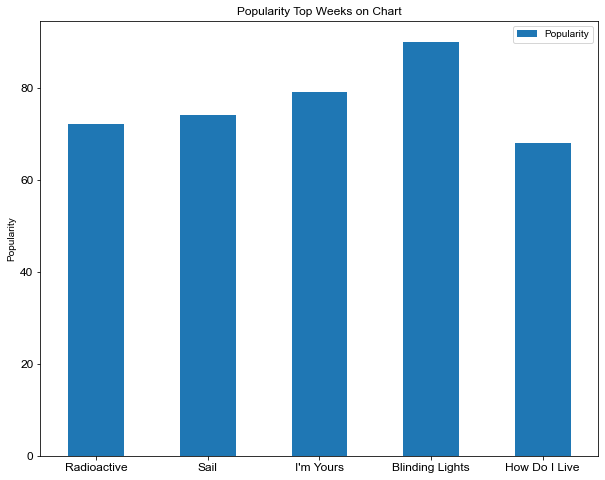

In [60]:
Title =  ['Radioactive', 'Sail', "I'm Yours", 'Blinding Lights', 'How Do I Live']
Popularity = [ 72, 74, 79, 90, 68]


df = pd.DataFrame({'Popularity' : Popularity }, index = Title)

ax = df.plot(kind='bar', figsize=(10,8), rot=0, title = 'Popularity Top Weeks on Chart', ylabel= 'Popularity')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()

# 1 Weeks

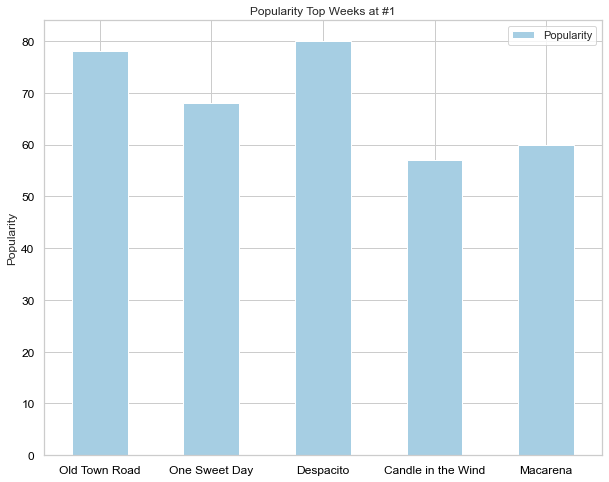

In [61]:
Title =  ['Old Town Road', 'One Sweet Day', 'Despacito', 'Candle in the Wind', 'Macarena']
Popularity = [78, 68, 80, 57, 60]


df = pd.DataFrame({'Popularity' : Popularity }, index = Title)

ax = df.plot(kind='bar', figsize=(10,8), rot=0, title = 'Popularity Top Weeks at #1', ylabel= 'Popularity')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()

# Combined Chart

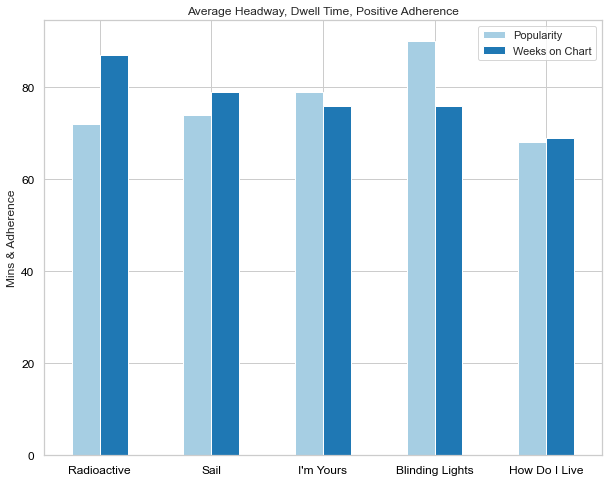

In [63]:
group_labels =  ['Radioactive', 'Sail', "I'm Yours", 'Blinding Lights', 'How Do I Live']
Popularity = [ 72, 74, 79, 90, 68]

Weeks_on_Chart = [87, 79, 76, 76, 69]


df = pd.DataFrame({'Popularity': Popularity, 'Weeks on Chart': Weeks_on_Chart}, index = group_labels)

ax = df.plot(kind='bar', figsize=(10,8), rot=0, title = 'Average Headway, Dwell Time, Positive Adherence', ylabel= 'Mins & Adherence')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()

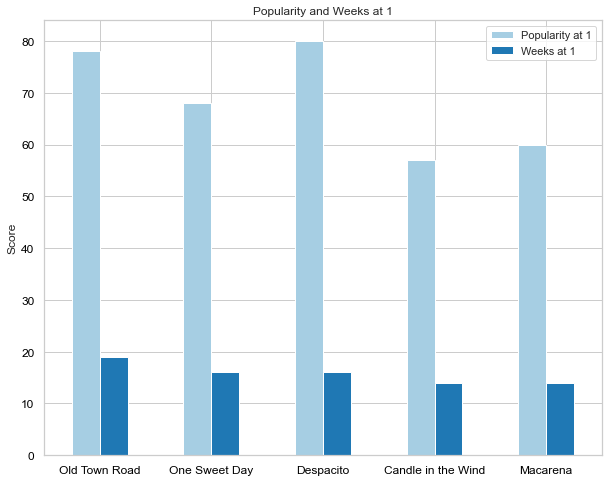

In [62]:
group_labels =  ['Old Town Road', 'One Sweet Day', 'Despacito', 'Candle in the Wind', 'Macarena' ]

Popularity_at_1= [78, 68, 80, 57, 60]

Weeks_at_1 = [19, 16, 16, 14, 14]

df = pd.DataFrame({'Popularity at 1': Popularity_at_1, 'Weeks at 1': Weeks_at_1}, index = group_labels)

ax = df.plot(kind='bar', figsize=(10,8), rot=0, title = 'Popularity and Weeks at 1', ylabel= 'Score')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()

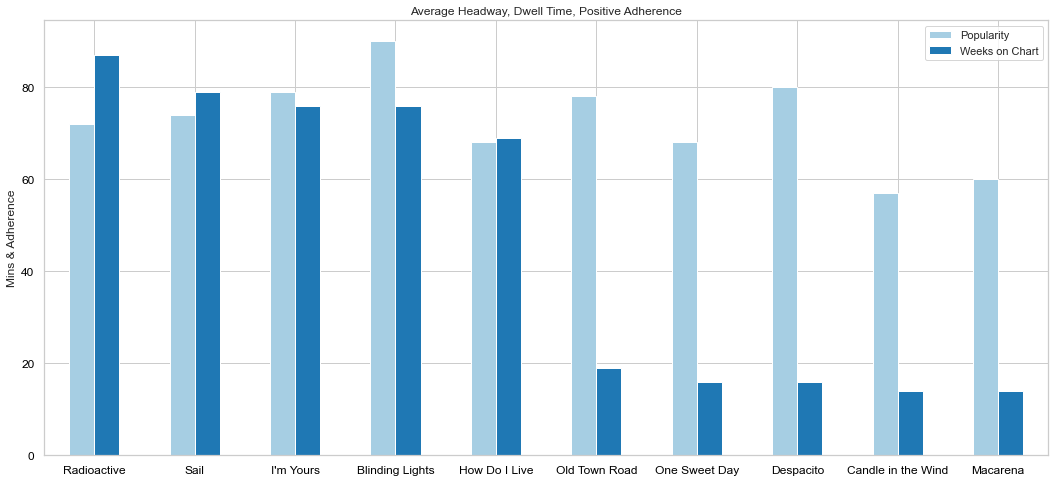

In [72]:
group_labels =  ['Radioactive', 'Sail', "I'm Yours", 'Blinding Lights', 'How Do I Live', 'Old Town Road', 'One Sweet Day', 'Despacito', 'Candle in the Wind', 'Macarena' ]

Popularity = [ 72, 74, 79, 90, 68, 78, 68, 80, 57, 60]

Weeks_on_Chart = [87, 79, 76, 76, 69, 19, 16, 16, 14, 14]


df = pd.DataFrame({'Popularity': Popularity, 'Weeks on Chart': Weeks_on_Chart}, index = group_labels)

ax = df.plot(kind='bar', figsize=(18,8), rot=0, title = 'Average Headway, Dwell Time, Positive Adherence', ylabel= 'Mins & Adherence')

ax.tick_params(
    axis="x", labelsize=12,
    labelcolor="black")
ax.tick_params(
    axis="y", labelsize=12,
    labelcolor="black")

sns.set_theme(style='whitegrid', palette=('Paired'), font='sans-serif', font_scale=1, color_codes=True, rc=None)

plt.show()
